In [1]:
# Importar las bibliotecas necesarias
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

Número de filas y columnas: (2557, 1) 

Tipo de datos:
 Load    int64
dtype: object 

Head:
                   Load
Date                  
2015-01-01  5686686080
2015-01-02  6752007030
2015-01-03  6605796020
2015-01-04  6273091530
2015-01-05  6760770300 



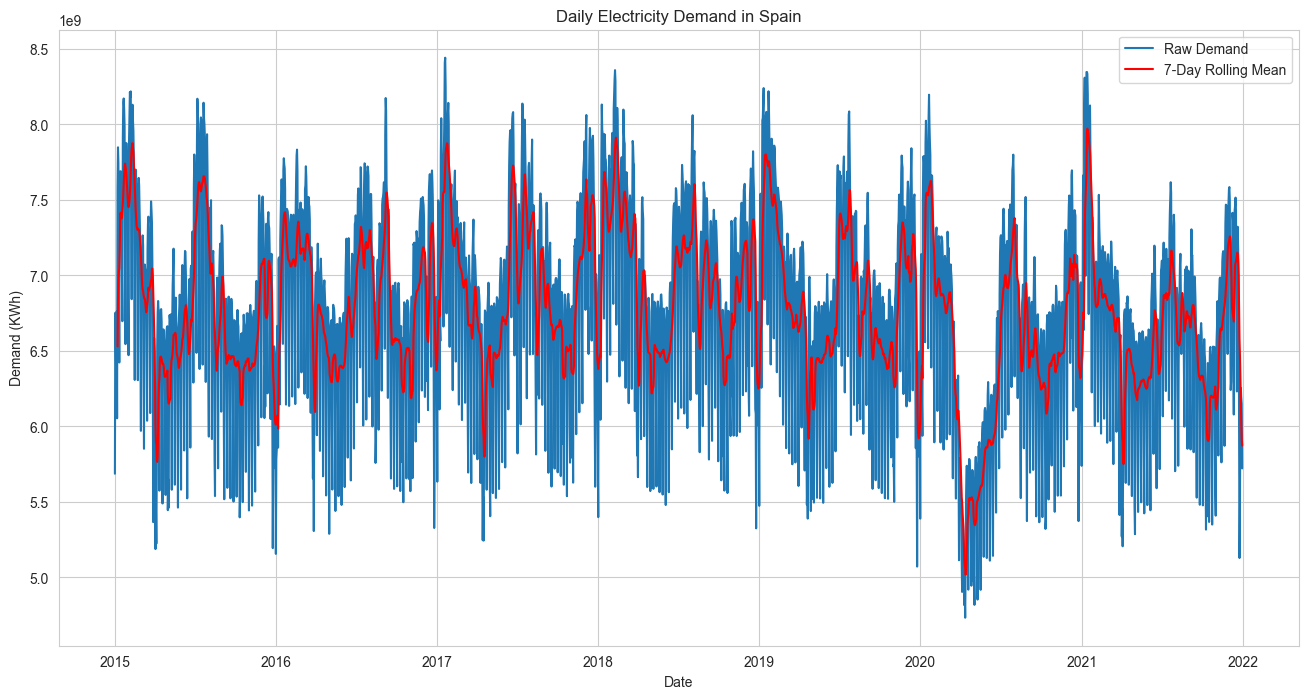

In [2]:
# Load dataset
path = os.getcwd()
fichero_DemandaDiaria = os.path.join(path, 'DemandaDiaria_KWh_2015-2021.csv')

# Read the data
data = pd.read_csv(fichero_DemandaDiaria, sep=";")
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Check the data
print("Número de filas y columnas:", data.shape, "\n")
print("Tipo de datos:\n", data.dtypes, "\n")
print("Head:\n", data.head(), "\n")

# Graph the data
sns.set_style("whitegrid")
rolling_mean = data['Load'].rolling(window=7).mean()
plt.figure(figsize=(16, 8))
plt.title('Daily Electricity Demand in Spain')
plt.xlabel('Date')
plt.ylabel('Demand (KWh)')
plt.plot(data.index, data['Load'], label='Raw Demand')
plt.plot(data.index, rolling_mean, color='red', label='7-Day Rolling Mean')
plt.legend(loc='best')
plt.show()

In [3]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Load'].values.reshape(-1, 1))

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Create sequences of length 'sequence_length' to use as input data
def create_sequences(dataset, sequence_length_scope):
    X, y = [], []
    # Iterate over the dataset and create sequences of length 'sequence_length'
    for i in range(len(dataset) - sequence_length_scope):
        # Add a sequence of length 'sequence_length' to X
        X.append(dataset[i:i + sequence_length_scope, 0])
        # Add the next data point after each sequence of length 'sequence_length' to y
        y.append(dataset[i + sequence_length_scope, 0])
    # Convert list to array
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the sequence for each input point
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Check the shape of the training sequences
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2035, 10)
y_train shape: (2035,)
X_test shape: (502, 10)
y_test shape: (502,)


In [4]:
# Function to train and evaluate SVR model with a given set of parameters
def SVM(parameters, return_predictions=False):
    C, gamma = parameters
    svr = SVR(kernel='rbf', C=C, gamma=gamma, verbose = False)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if return_predictions:
        return mse, y_pred
    else:
        return mse

In [5]:
class GreyWolfOptimizer:
    """
    Grey Wolf Optimizer (GWO) implementation.
    Note: This implementation is designed for minimization problems.
    """

    def __init__(self, n_agents, function, lb, ub, dimension, n_iterations):
        """
        :param n_agents: Number of agents (wolves)
        :param function: Fitness function to be minimized
        :param lb: Lower bound of the search space
        :param ub: Upper bound of the search space
        :param dimension: Dimension of the search space
        :param n_iterations: Number of iterations
        """
        self.n_agents = n_agents
        self.function = function
        self.lb = lb
        self.ub = ub
        self.dimension = dimension
        self.n_iterations = n_iterations
        self.agents = np.random.uniform(self.lb, self.ub, (self.n_agents, self.dimension))
        self.alpha, self.beta, self.delta, self.fitness_alpha, self.alpha_id = self._get_abd()
        self.global_best = self.alpha
        self.fitness_global_best = self.fitness_alpha
        self.global_best_iter = 0
        self.global_best_id = self.alpha_id + 1
        self.start_time = datetime.now()

    def _get_abd(self):
        """
        Function to identify the three best wolves (alpha, beta, delta)
        :return: The positions and fitness of the three best wolves
        """
        fitness = [(self.function(self.agents[i]), i) for i in range(self.n_agents)]
        fitness.sort()
        alpha, beta, delta = [self.agents[fitness[i][1]] for i in range(3)]
        fitness_alpha = fitness[0][0]
        alpha_id = fitness[0][1]
        return alpha, beta, delta, fitness_alpha, alpha_id

    def optimize(self):
        """
        Main optimization loop
        :return: The global best position and its fitness
        """
        for t in range(self.n_iterations):
            a = 2 - 2 * t / self.n_iterations  # Update the 'a' parameter

            # Compute the position update components for all agents
            D_alpha, D_beta, D_delta = [self._compute_position_update(a, wolf) for wolf in [self.alpha, self.beta, self.delta]]

            # Update the positions of all agents
            self.agents = (D_alpha + D_beta + D_delta) / 3
            self.agents = np.clip(self.agents, self.lb, self.ub)  # Clip to the search space bounds

            # Update alpha, beta, delta
            self.alpha, self.beta, self.delta, self.fitness_alpha, self.alpha_id = self._get_abd()

            # If a better alpha is found, update the global best position and its fitness
            if self.fitness_alpha < self.fitness_global_best:
                self.global_best = self.alpha
                self.fitness_global_best = self.fitness_alpha
                self.global_best_iter = t + 1
                self.global_best_id = self.alpha_id + 1

            # Print the current iteration results
            elapsed_time = datetime.now() - self.start_time
            print(f"Iteration {t+1}: Global best position: {self.global_best}, fitness: {self.fitness_global_best}, found by agent {self.global_best_id} in iteration {self.global_best_iter}, elapsed time: {elapsed_time}")

        return self.global_best, self.fitness_global_best

    def _compute_position_update(self, a, wolf):
        """
        Compute the position update for a given wolf
        :param a: The 'a' parameter
        :param wolf: The position of the wolf
        :return: The position update
        """
        r1 = np.random.random((self.n_agents, self.dimension))
        r2 = np.random.random((self.n_agents, self.dimension))
        A = 2 * r1 * a - a
        C = 2 * r2
        D = abs(C * wolf - self.agents)
        return wolf - A * D


In [6]:
# Define the search space
lb = [0.01, 0.01]  # Lower bounds for the parameters
ub = [10.0, 1]  # Upper bounds for the parameters

# Define the GWO parameters
n_agents = 5  # Number of agents
n_iterations = 10  # Number of iterations

# Create an instance of the GreyWolfOptimizer class
gwo = GreyWolfOptimizer(n_agents, SVM, lb, ub, 2, n_iterations)

# Run the GWO algorithm
best_position, _ = gwo.optimize()

# Train and evaluate the SVM model with the best parameters
mse, y_pred = SVM(best_position, return_predictions=True)

Iteration 1: Global best position: [6.32959165 0.56957155], fitness: 0.004477140911574749, found by agent 1 in iteration 0, elapsed time: 0:00:00.271121
Iteration 2: Global best position: [5.63094996 0.57931536], fitness: 0.004471116937291836, found by agent 1 in iteration 2, elapsed time: 0:00:00.545856
Iteration 3: Global best position: [4.6482988  0.58872939], fitness: 0.0044669795967591415, found by agent 3 in iteration 3, elapsed time: 0:00:00.818486
Iteration 4: Global best position: [4.6482988  0.58872939], fitness: 0.0044669795967591415, found by agent 3 in iteration 3, elapsed time: 0:00:01.072379
Iteration 5: Global best position: [4.6482988  0.58872939], fitness: 0.0044669795967591415, found by agent 3 in iteration 3, elapsed time: 0:00:01.335817
Iteration 6: Global best position: [4.6482988  0.58872939], fitness: 0.0044669795967591415, found by agent 3 in iteration 3, elapsed time: 0:00:01.605180
Iteration 7: Global best position: [4.6482988  0.58872939], fitness: 0.0044669

In [7]:
# Invert the normalization for y_pred and y_test
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test_original, y_pred_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# Calculate MRAE (Mean Absolute Percentage Error)
mrae = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

# Print metrics
print('MAE: {:,.2f}'.format(mae))
print('RMSE: {:,.2f}'.format(rmse))
print('MRAE: {:,.2f} %'.format(mrae))

MAE: 177,277,139.39
RMSE: 247,829,834.76
MRAE: 2.73 %


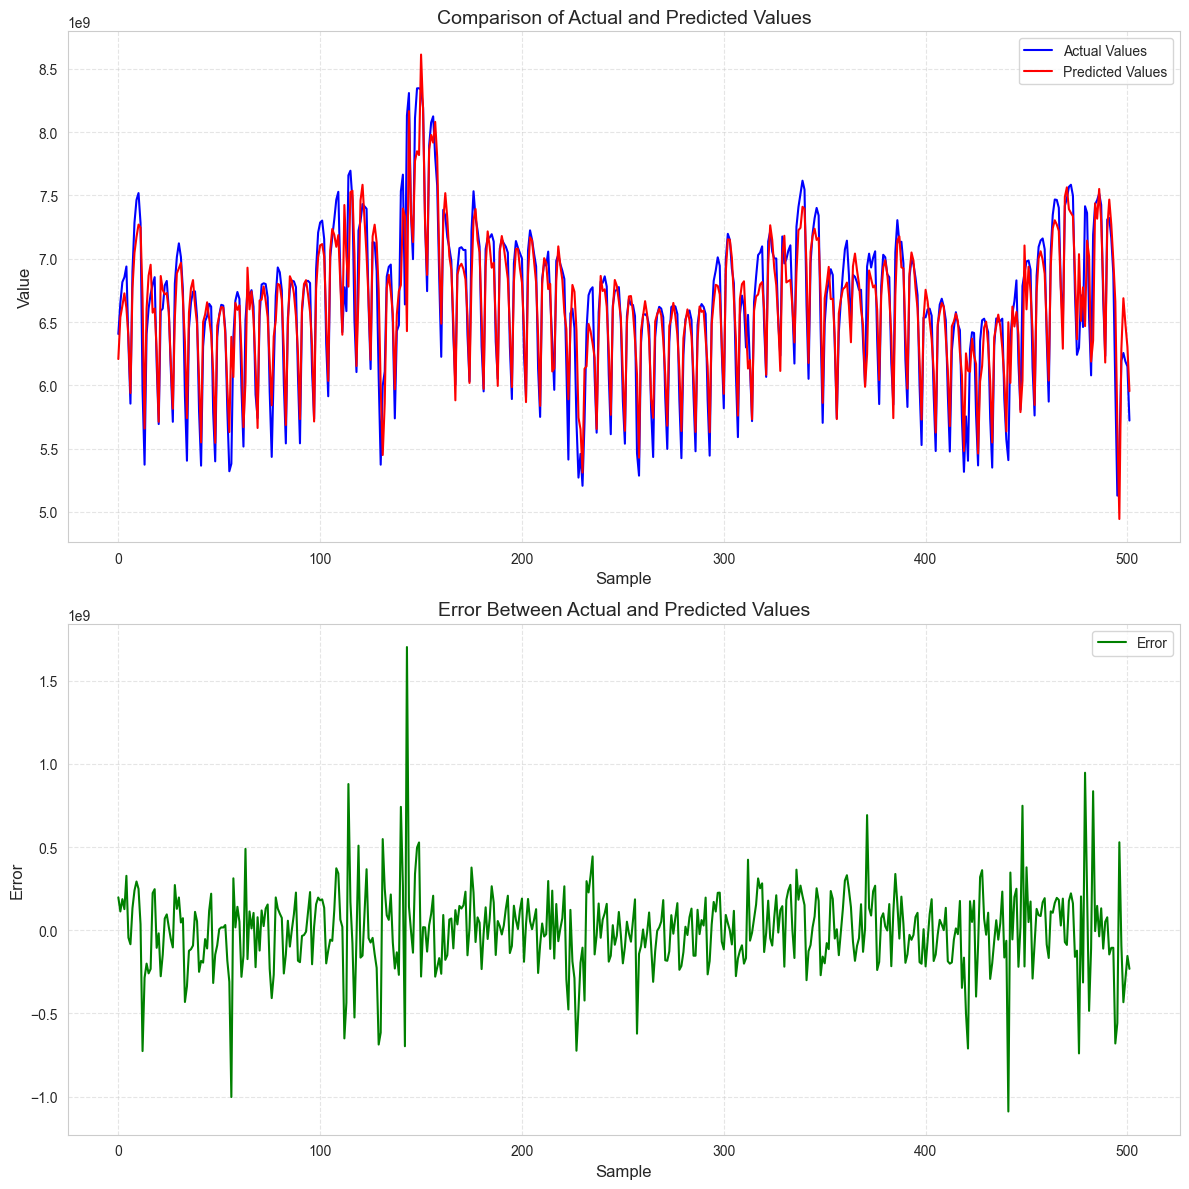

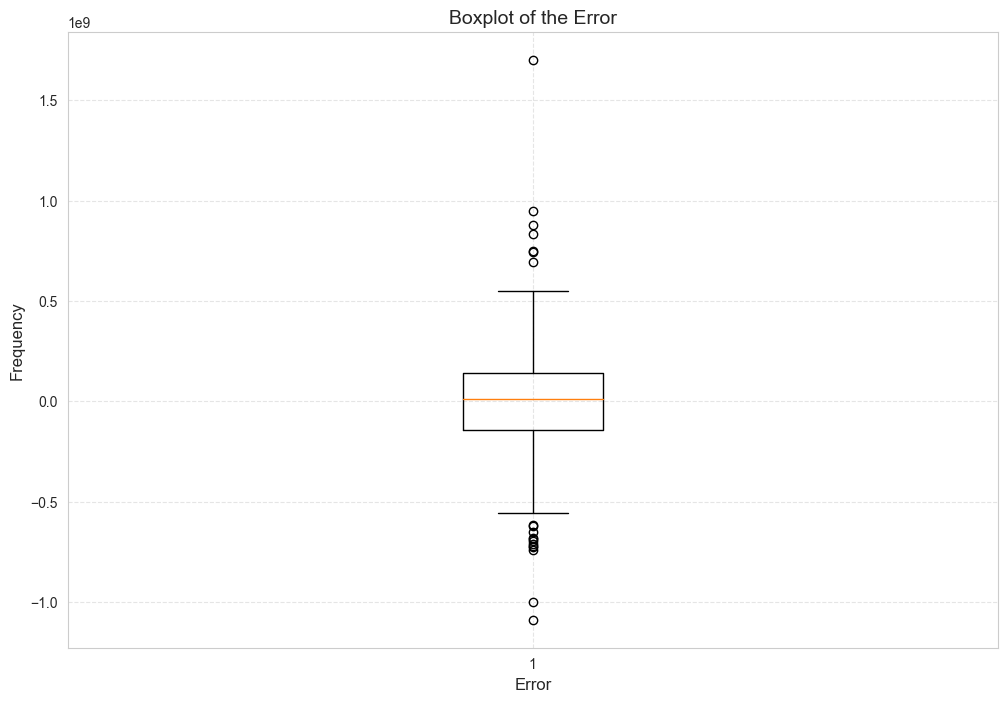

In [8]:
# Calculate the error between actual and predicted values
error = y_test_original - y_pred_original

# Create a figure and a set of subplots (2 subplots)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the actual vs predicted values in the first subplot
axes[0].plot(y_test_original, label='Actual Values', color='blue')
axes[0].plot(y_pred_original, label='Predicted Values', color='red')
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Comparison of Actual and Predicted Values', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot the error in the second subplot
axes[1].plot(error, label='Error', color='green')
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('Error Between Actual and Predicted Values', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Show the plots
plt.tight_layout()
plt.show()

# Boxplot of the error
plt.figure(figsize=(12, 8))
plt.boxplot(error)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Boxplot of the Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()